In [27]:
#Library import and initiation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
transaction_df = pd.read_csv('transaction_merged_1.csv')

In [3]:
print(transaction_df.dtypes)

OPERATION_CORE_ID     object
COMPANY               object
PRODUCT_ID             int64
OPERATION_CODE         int64
OPERATION_DATE        object
CURRENCY              object
CURRENCY_AMOUNT      float64
AMOUNT               float64
ACCOUNT_ID             int64
CUST_ID                int64
DEBIT_CREDIT_FLAG     object
FISCAL_COUNTRY        object
CITY                  object
STATE                 object
ZIPCODE               object
RISK_LEVEL             int64
NAT_COUNTRY           object
BALANCE              float64
OPEN_DATE             object
dtype: object


In [4]:
numerical_columns = transaction_df.select_dtypes(include=['number']).columns
categorical_columns = transaction_df.select_dtypes(include=['object', 'boolean', 'category']).columns

In [5]:
print(numerical_columns)

Index(['PRODUCT_ID', 'OPERATION_CODE', 'CURRENCY_AMOUNT', 'AMOUNT',
       'ACCOUNT_ID', 'CUST_ID', 'RISK_LEVEL', 'BALANCE'],
      dtype='object')


In [6]:
print(categorical_columns)

Index(['OPERATION_CORE_ID', 'COMPANY', 'OPERATION_DATE', 'CURRENCY',
       'DEBIT_CREDIT_FLAG', 'FISCAL_COUNTRY', 'CITY', 'STATE', 'ZIPCODE',
       'NAT_COUNTRY', 'OPEN_DATE'],
      dtype='object')


In [7]:
#converting required columns from categorical to numerical

#converting 'OPERATION_DATE' column from object('Datetime') to int('timestamp')
#commented this code set as if it is executed again data will get modified.  Need to uncomment when the dataset is loaded again to dataframe
transaction_df['OPERATION_DATE']=pd.to_datetime(transaction_df['OPERATION_DATE'])
transaction_df['OPERATION_DATE'] = transaction_df['OPERATION_DATE'].apply(lambda x:x.timestamp())
transaction_df['OPERATION_DATE']=transaction_df['OPERATION_DATE'].astype(int)

print(transaction_df['OPERATION_DATE'].head())



0    1710720000
1    1710892800
2    1710460800
3    1713484800
4    1713312000
Name: OPERATION_DATE, dtype: int32


In [8]:
#converting 'OPERATION_CODE' column from object to int
transaction_df['OPERATION_CODE'] = transaction_df['OPERATION_CODE'].astype(int)

In [9]:
# replacing null values of STATE column with Barbados
transaction_df['STATE'].fillna('Barbados', inplace=True)

In [10]:
print(transaction_df['STATE'].isnull().value_counts())

STATE
False    49861
Name: count, dtype: int64


In [11]:
# replacing null values of ZIPCODE with BB15028
transaction_df['ZIPCODE'].fillna('BB15028', inplace=True)

In [12]:
print(transaction_df['ZIPCODE'].isnull().value_counts())

ZIPCODE
False    49861
Name: count, dtype: int64


In [13]:
print(transaction_df.select_dtypes(include='number').describe().round(2))

       PRODUCT_ID  OPERATION_CODE  OPERATION_DATE  CURRENCY_AMOUNT  \
count    49861.00        49861.00    4.986100e+04         49861.00   
mean      5705.28         2986.08    1.669442e+09        102165.87   
std        799.45         2173.02    2.927875e+07        678441.90   
min       1001.00            1.00    1.628813e+09             0.09   
25%       6001.00          833.00    1.639094e+09           100.00   
50%       6003.00         5025.00    1.667261e+09          3271.38   
75%       6003.00         5028.00    1.701043e+09         79000.00   
max       6008.00         5045.00    1.715904e+09      50000000.00   

            AMOUNT    ACCOUNT_ID     CUST_ID  RISK_LEVEL      BALANCE  
count     49861.00  4.986100e+04    49861.00    49861.00     49654.00  
mean     103168.12  1.063598e+10  1001772.88       79.74    459796.10  
std      680224.17  6.641850e+09     1703.68       16.81   2773984.78  
min           0.01  1.000000e+10  1000005.00       26.00  -3021846.06  
25%      

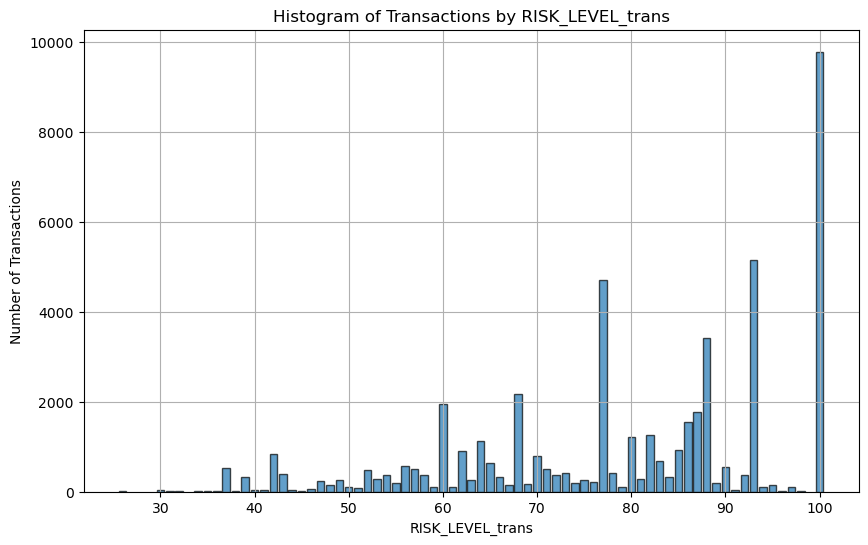

In [14]:
risk_level_counts = transaction_df['RISK_LEVEL'].value_counts().sort_index()

# Plot the histogram for RISK_LEVEL_trans
plt.figure(figsize=(10, 6))
plt.bar(risk_level_counts.index, risk_level_counts.values, edgecolor='black', alpha=0.7)
plt.title('Histogram of Transactions by RISK_LEVEL_trans')
plt.xlabel('RISK_LEVEL_trans')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

In [15]:
additional_percentiles=[0.90,0.92,0.93,0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
#account_id = 10000000127
amount_summary=transaction_df.groupby('ACCOUNT_ID')['CURRENCY_AMOUNT'].describe(percentiles=additional_percentiles).round(2)
# print(amount_summary.loc[account_id, '98%'])
#print(amount_summary['99%'])

for transaction_index, transaction_row in transaction_df.iterrows():
    if transaction_df.loc[transaction_index,'CURRENCY_AMOUNT'] > amount_summary.loc[transaction_df.loc[transaction_index, 'ACCOUNT_ID'],'99%'] and transaction_df.loc[transaction_index,'RISK_LEVEL']>60:
        transaction_df.loc[transaction_index,'FRAUD'] = 1
    else:
        transaction_df.loc[transaction_index,'FRAUD'] = 0

print(transaction_df['FRAUD'].value_counts())

FRAUD
0.0    49147
1.0      714
Name: count, dtype: int64


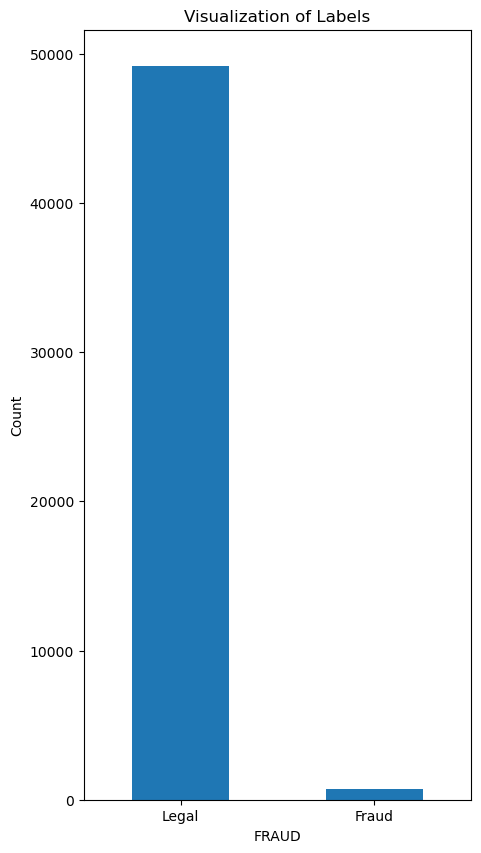

In [16]:
plt.figure(figsize=(5,10))
labels = ["Legal", "Fraud"]
count_classes = transaction_df.value_counts(transaction_df['FRAUD'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

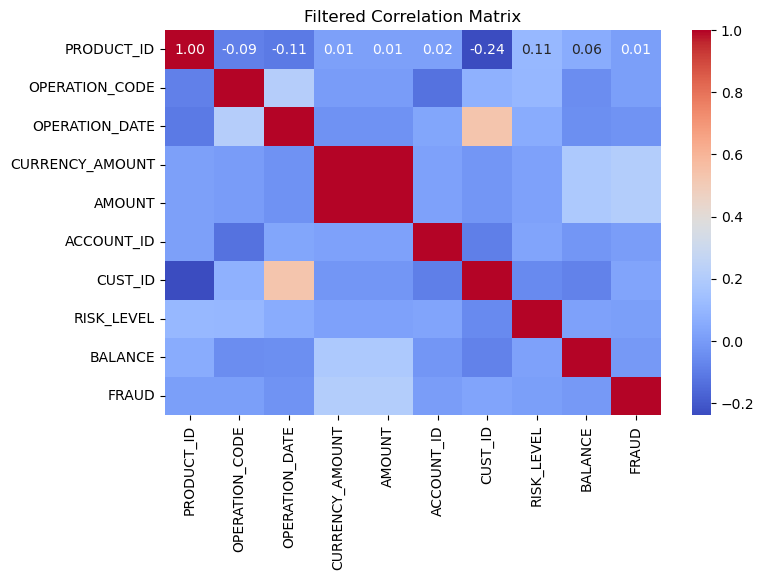

Significant columns for EDA and ML:
Index(['PRODUCT_ID', 'OPERATION_CODE', 'OPERATION_DATE', 'CURRENCY_AMOUNT',
       'AMOUNT', 'ACCOUNT_ID', 'CUST_ID', 'RISK_LEVEL', 'BALANCE', 'FRAUD'],
      dtype='object')


In [17]:
correlation_matrix = transaction_df.select_dtypes(include='number').corr()
significant_columns = correlation_matrix.columns[correlation_matrix.abs().sum() > 0.5]
transaction_df_filtered = transaction_df[significant_columns]
# Plot the correlation matrix for the filtered DataFrame
plt.figure(figsize=(8,5))
sns.heatmap(transaction_df_filtered.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Filtered Correlation Matrix')
plt.show()

# Display the significant columns
print("Significant columns for EDA and ML:")
print(significant_columns)

From the Correlation matrix of all the numerical columns of the dataset, significant correlation is observerd only between the 'OPERATION_DATE' & 'CUST_ID' columns other the self correlation.

Rest of the columns does not provide much correlation between them.

In [18]:
compare_column = 'FRAUD'
for column in categorical_columns:
    if column != compare_column:  # Skip comparing the column with itself
        # Create contingency table using crosstab
        contingency_table = pd.crosstab(index=transaction_df[compare_column], columns=transaction_df[column])

        print(f"\nChi-squared test between '{compare_column}' and '{column}':")
        #print("Contingency Table:")
        #print(contingency_table)

        # Perform chi-squared test
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        print("\nChi-squared statistic:", chi2)
        print("P-value:", p_value.round(3))
        print("Degrees of freedom:", dof)
        print("Expected frequencies:")
        print(expected)


Chi-squared test between 'FRAUD' and 'OPERATION_CORE_ID':

Chi-squared statistic: 49648.456416464884
P-value: 0.0
Degrees of freedom: 45877
Expected frequencies:
[[1.97136038 1.97136038 0.98568019 ... 0.98568019 0.98568019 1.97136038]
 [0.02863962 0.02863962 0.01431981 ... 0.01431981 0.01431981 0.02863962]]

Chi-squared test between 'FRAUD' and 'COMPANY':

Chi-squared statistic: 1.4329366132632755
P-value: 0.231
Degrees of freedom: 1
Expected frequencies:
[[4.87004869e+04 4.46513126e+02]
 [7.07513126e+02 6.48687351e+00]]

Chi-squared test between 'FRAUD' and 'OPERATION_DATE':

Chi-squared statistic: 2963.540338832235
P-value: 0.0
Degrees of freedom: 707
Expected frequencies:
[[3.35131265e+01 5.18467780e+02 1.39966587e+02 ... 1.01525060e+02
  1.97136038e+00 1.97136038e+00]
 [4.86873508e-01 7.53221957e+00 2.03341289e+00 ... 1.47494033e+00
  2.86396181e-02 2.86396181e-02]]

Chi-squared test between 'FRAUD' and 'CURRENCY':

Chi-squared statistic: 42.96321556382385
P-value: 0.0
Degrees of 

In [ ]:
# sns.heatmap(transaction_df, annot=True, cmap="YlGnBu", cbar=False, fmt='d')
# plt.title('Observed Frequencies')
# plt.show()

# sns.heatmap(transaction_df.select_dtypes(include=['object', 'category']).corr(), annot=True, cmap="coolwarm", cbar=True, fmt='.1f')
# plt.title('Expected Frequencies')
# plt.show()

In [20]:
df=transaction_df
print(df.head())

             OPERATION_CORE_ID    COMPANY  PRODUCT_ID  OPERATION_CODE  \
0       205325480555824.010001  KN0010001        5001            5025   
1  F20240320.20534424734162001  KN0010001        5001            5026   
2       205298009844406.010001  KN0010001        5001            5028   
3  F20240419.20564482075159400  KN0010001        5001            5026   
4  F20240417.20562942110304000  KN0010001        5001            5026   

   OPERATION_DATE CURRENCY  CURRENCY_AMOUNT    AMOUNT   ACCOUNT_ID  CUST_ID  \
0      1710720000      USD              5.0       5.0  10000019386  1004808   
1      1710892800      USD         100000.0  100000.0  10000019386  1004808   
2      1710460800      USD           1000.0    1000.0  10000019386  1004808   
3      1713484800      USD         100000.0  100000.0  10000019386  1004808   
4      1713312000      USD         100000.0  100000.0  10000019386  1004808   

  DEBIT_CREDIT_FLAG FISCAL_COUNTRY     CITY    STATE  ZIPCODE  RISK_LEVEL  \
0        

In [21]:
df = transaction_df
df=df.dropna(subset=['BALANCE'])
print(df.isnull().value_counts())

# Drop irrelevant columns for PCA analysis
df.drop(['OPERATION_CORE_ID', 'COMPANY', 'PRODUCT_ID', 'OPERATION_DATE', 'CURRENCY', 'ACCOUNT_ID', 
         'CUST_ID', 'FISCAL_COUNTRY', 'CITY', 'STATE', 'ZIPCODE', 'NAT_COUNTRY', 'OPEN_DATE'], axis=1, inplace=True)

# Convert categorical variables to numerical using one-hot encoding
categorical_cols = ['DEBIT_CREDIT_FLAG']
numerical_cols = ['OPERATION_CODE', 'CURRENCY_AMOUNT', 'AMOUNT', 'RISK_LEVEL', 'BALANCE']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

X_processed = preprocessor.fit_transform(df)

# Convert processed data back to a DataFrame (optional)
df_processed = pd.DataFrame(X_processed, columns=numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out()))

# Check the processed DataFrame
print(df_processed.head())

OPERATION_CORE_ID  COMPANY  PRODUCT_ID  OPERATION_CODE  OPERATION_DATE  CURRENCY  CURRENCY_AMOUNT  AMOUNT  ACCOUNT_ID  CUST_ID  DEBIT_CREDIT_FLAG  FISCAL_COUNTRY  CITY   STATE  ZIPCODE  RISK_LEVEL  NAT_COUNTRY  BALANCE  OPEN_DATE  FRAUD
False              False    False       False           False           False     False            False   False       False    False              False           False  False  False    False       False        False    False      False    47895
                                                                                                                                                                   True   False  False    False       False        False    False      False     1568
                                                                                                                                                                   False  False  False    False       False        False    True       False      191
Name: count, dtype: int64

C:\Users\bharath.venkatesan\AppData\Local\Temp\ipykernel_26636\505761832.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['OPERATION_CORE_ID', 'COMPANY', 'PRODUCT_ID', 'OPERATION_DATE', 'CURRENCY', 'ACCOUNT_ID',


In [22]:
# Perform PCA
pca = PCA(n_components=2)  # Specify the number of components
X_pca = pca.fit_transform(X_processed)

# Convert PCA results to DataFrame for analysis
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Optional: Check explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)

# Optional: Print principal components
print("Principal components:")
print(pca.components_)

# Optional: Concatenate PCA results with original DataFrame
df_final = pd.concat([df_processed, df_pca], axis=1)

# View the final DataFrame with PCA components
print(df_final.head())

Explained variance ratio: [0.3798595  0.20316278]
Principal components:
[[-0.00490415  0.68599613  0.68592776  0.02887074  0.23990188  0.01584207
  -0.01584207]
 [-0.71211346 -0.01076343 -0.01080646 -0.68664003  0.13486534 -0.03872071
   0.03872071]]
   OPERATION_CODE  CURRENCY_AMOUNT    AMOUNT  RISK_LEVEL   BALANCE  \
0        0.937502        -0.150727 -0.151807    1.203981 -1.255118   
1        0.937962        -0.003618 -0.005083    1.203981 -1.255118   
2        0.938883        -0.149263 -0.150347    1.203981 -1.255118   
3        0.937962        -0.003618 -0.005083    1.203981 -1.255118   
4        0.937962        -0.003618 -0.005083    1.203981 -1.255118   

   DEBIT_CREDIT_FLAG_C  DEBIT_CREDIT_FLAG_D       PC1       PC2  
0                  0.0                  1.0 -0.488743 -1.635208  
1                  0.0                  1.0 -0.287187 -1.638705  
2                  0.0                  1.0 -0.486744 -1.636223  
3                  0.0                  1.0 -0.287187 -1.638705 

In [23]:
df=transaction_df
df=df.dropna(subset=['BALANCE'])

#Random Forest Model
X = df.drop(['FRAUD'], axis=1)  # Features
y = df['FRAUD']  # Target variable

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators as needed

# Create pipeline with preprocessing and model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

# Train the model
clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
#print(f"Accuracy: {accuracy}")

# Predictions on the test set
y_pred = clf.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[9790    5]
 [ 115   21]]


In [24]:

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")



Accuracy: 0.9879166247105025


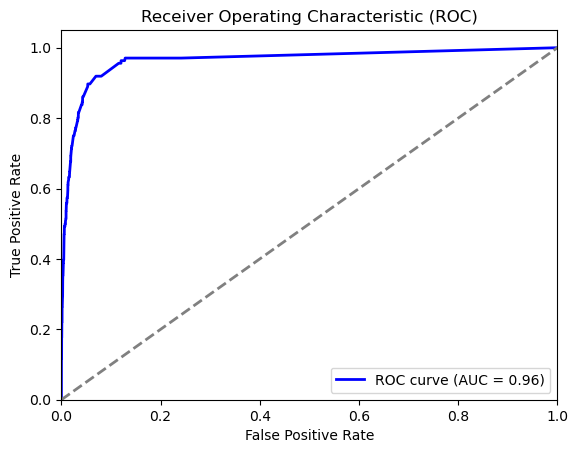

In [28]:
y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)


plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
